In [43]:
#!/usr/bin/python

import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_selection import SelectKBest
import numpy
import pandas
import math
#sys.path.append("../tools/")
#%matplotlib inline
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from tester import main
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [18]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','bonus','total_stock_value','exercised_stock_options','total_payments',\
                 'long_term_incentive'] # You will need to use more features

financial_features_list = ['poi','salary','bonus','deferral_payments','deferred_income','director_fees',\
                           'exercised_stock_options','expenses','loan_advances','long_term_incentive',\
                           'restricted_stock','restricted_stock_deferred','total_payments','total_stock_value']

email_feature_list = ['poi','to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',\
                      'shared_receipt_with_poi','fraction_from_poi','fraction_to_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
print 'number of people in data set = ', len(data_dict)
print 'Number of features for every person in the data set:\n', len(data_dict['LAY KENNETH L'].keys())
# of POIs
count = 0
for p in data_dict:
    for i in data_dict[p]:
        if i == "poi":
            if data_dict[p][i] == 1:
                count +=1
print ("There are %d POIs" % (count))
print ("There are %d non POIs" %(146-count))

number of people in data set =  146
Number of features for every person in the data set:
21
There are 18 POIs
There are 128 non POIs


In [19]:
### Task 2: Remove outliers
''' as seen in the outliers section, we saw that there was a "Total" entry in the data set that was a clear outlier.
thus we are removing it
'''
print "length of data set before removing outlier = ", len(data_dict)
data_dict.pop("TOTAL",0)
print "length of data set after removing outlier = ", len(data_dict)



length of data set before removing outlier =  146
length of data set after removing outlier =  145


In [20]:
# Load up data into pandas DF to explore for additional outliers
df = pandas.DataFrame.from_records(list(data_dict.values()))
employees = pandas.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)
#replace string NaNs with numpy object NaN
df.replace('NaN',numpy.nan, inplace=True)
                          
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299.0,29.0,38.0,1.0,...,NaN,1740.0,False,585062.0,NaN,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,NaN,NaN,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,NaN,-400729.0,NaN,steven.elliott@enron.com,4890344.0,78552.0,NaN,NaN,NaN,...,NaN,12961.0,False,1788391.0,NaN,170941.0,NaN,NaN,211725.0,6678735.0
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850.0,NaN,12.0,10.0,0.0,...,NaN,NaN,False,386335.0,NaN,NaN,58.0,764.0,NaN,1038185.0
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0


In [21]:
# check individuals for outliers 
df.index.values.tolist()

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNCAN JOHN H'

In [22]:
# check for additional outliers and NaNs by row
sum_nans_rows = df.isnull().sum(axis=1)
print sum_nans_rows[sum_nans_rows == sum_nans_rows.max()]
print df.loc['LOCKHART EUGENE E']

LOCKHART EUGENE E    20
dtype: int64
bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object


After adding my new features to the dataset, I decided to check for more outliers by checking the names in the data set and checking if there were any individuals that had missing data for every features. After doing this, I identified 2 more outliers:
 - 'THE TRAVEL AGENCY IN THE PARK'
 - 'Lockhart Eugene E'
 
The Travel Agency in the Park is clearly not an individual and Eugene is not a POI, therefore i am going to remove them from the data set. 

In [23]:
#remove additional outliers
data_dict.pop("THE TRAVEL AGENCY IN THE PARK",0)
data_dict.pop("LOCKHART EUGENE E",0)
# Verify outliers were removed. Length should be 143
print "length of data set after removing outliers = ", len(data_dict)

length of data set after removing outliers =  143


In [24]:
### Task 3: Create new feature(s)
# Helper function
def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    poi_messages = float(poi_messages)
    all_messages = float(all_messages)
    
    #print "poi_messages = ", poi_messages
    #print "all_messages = ", all_messages
    #if poi_messages=="NaN" or all_messages =="NaN" or all_messages== 0 :
    #    fraction = 0.0
    if math.isnan(poi_messages) or math.isnan(all_messages):
        fraction = 0.0
    else: 
        fraction = float(poi_messages/all_messages)
        if math.isnan(fraction):
            fraction = 0.0
    return fraction
# Compute fraction from poi and to poi
for name in data_dict:
    data_dict[name]['fraction_from_poi'] = computeFraction( data_dict[name]['from_poi_to_this_person'],\
                                                           data_dict[name]['to_messages'] )
    data_dict[name]['fraction_to_poi'] = computeFraction( data_dict[name]['from_this_person_to_poi'],\
                                                           data_dict[name]['from_messages'] )
    


### Store to my_dataset for easy export below.
my_dataset=data_dict


In [25]:
# Verify new features have been added correctly to the data set.
df = pandas.DataFrame.from_records(list(data_dict.values()))
employees = pandas.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)
df.replace('NaN',numpy.nan, inplace=True)
                          
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,fraction_from_poi,fraction_to_poi,from_messages,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299.0,0.047088,0.034483,29.0,...,NaN,1740.0,False,585062.0,NaN,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,NaN,NaN,6680544.0,11200.0,0.000000,0.000000,NaN,...,1586055.0,2660303.0,False,3942714.0,NaN,267102.0,NaN,NaN,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,NaN,-400729.0,NaN,steven.elliott@enron.com,4890344.0,78552.0,0.000000,0.000000,NaN,...,NaN,12961.0,False,1788391.0,NaN,170941.0,NaN,NaN,211725.0,6678735.0
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850.0,NaN,0.013089,0.000000,12.0,...,NaN,NaN,False,386335.0,NaN,NaN,58.0,764.0,NaN,1038185.0
HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,0.030622,0.656250,32.0,...,1617011.0,11350.0,True,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0


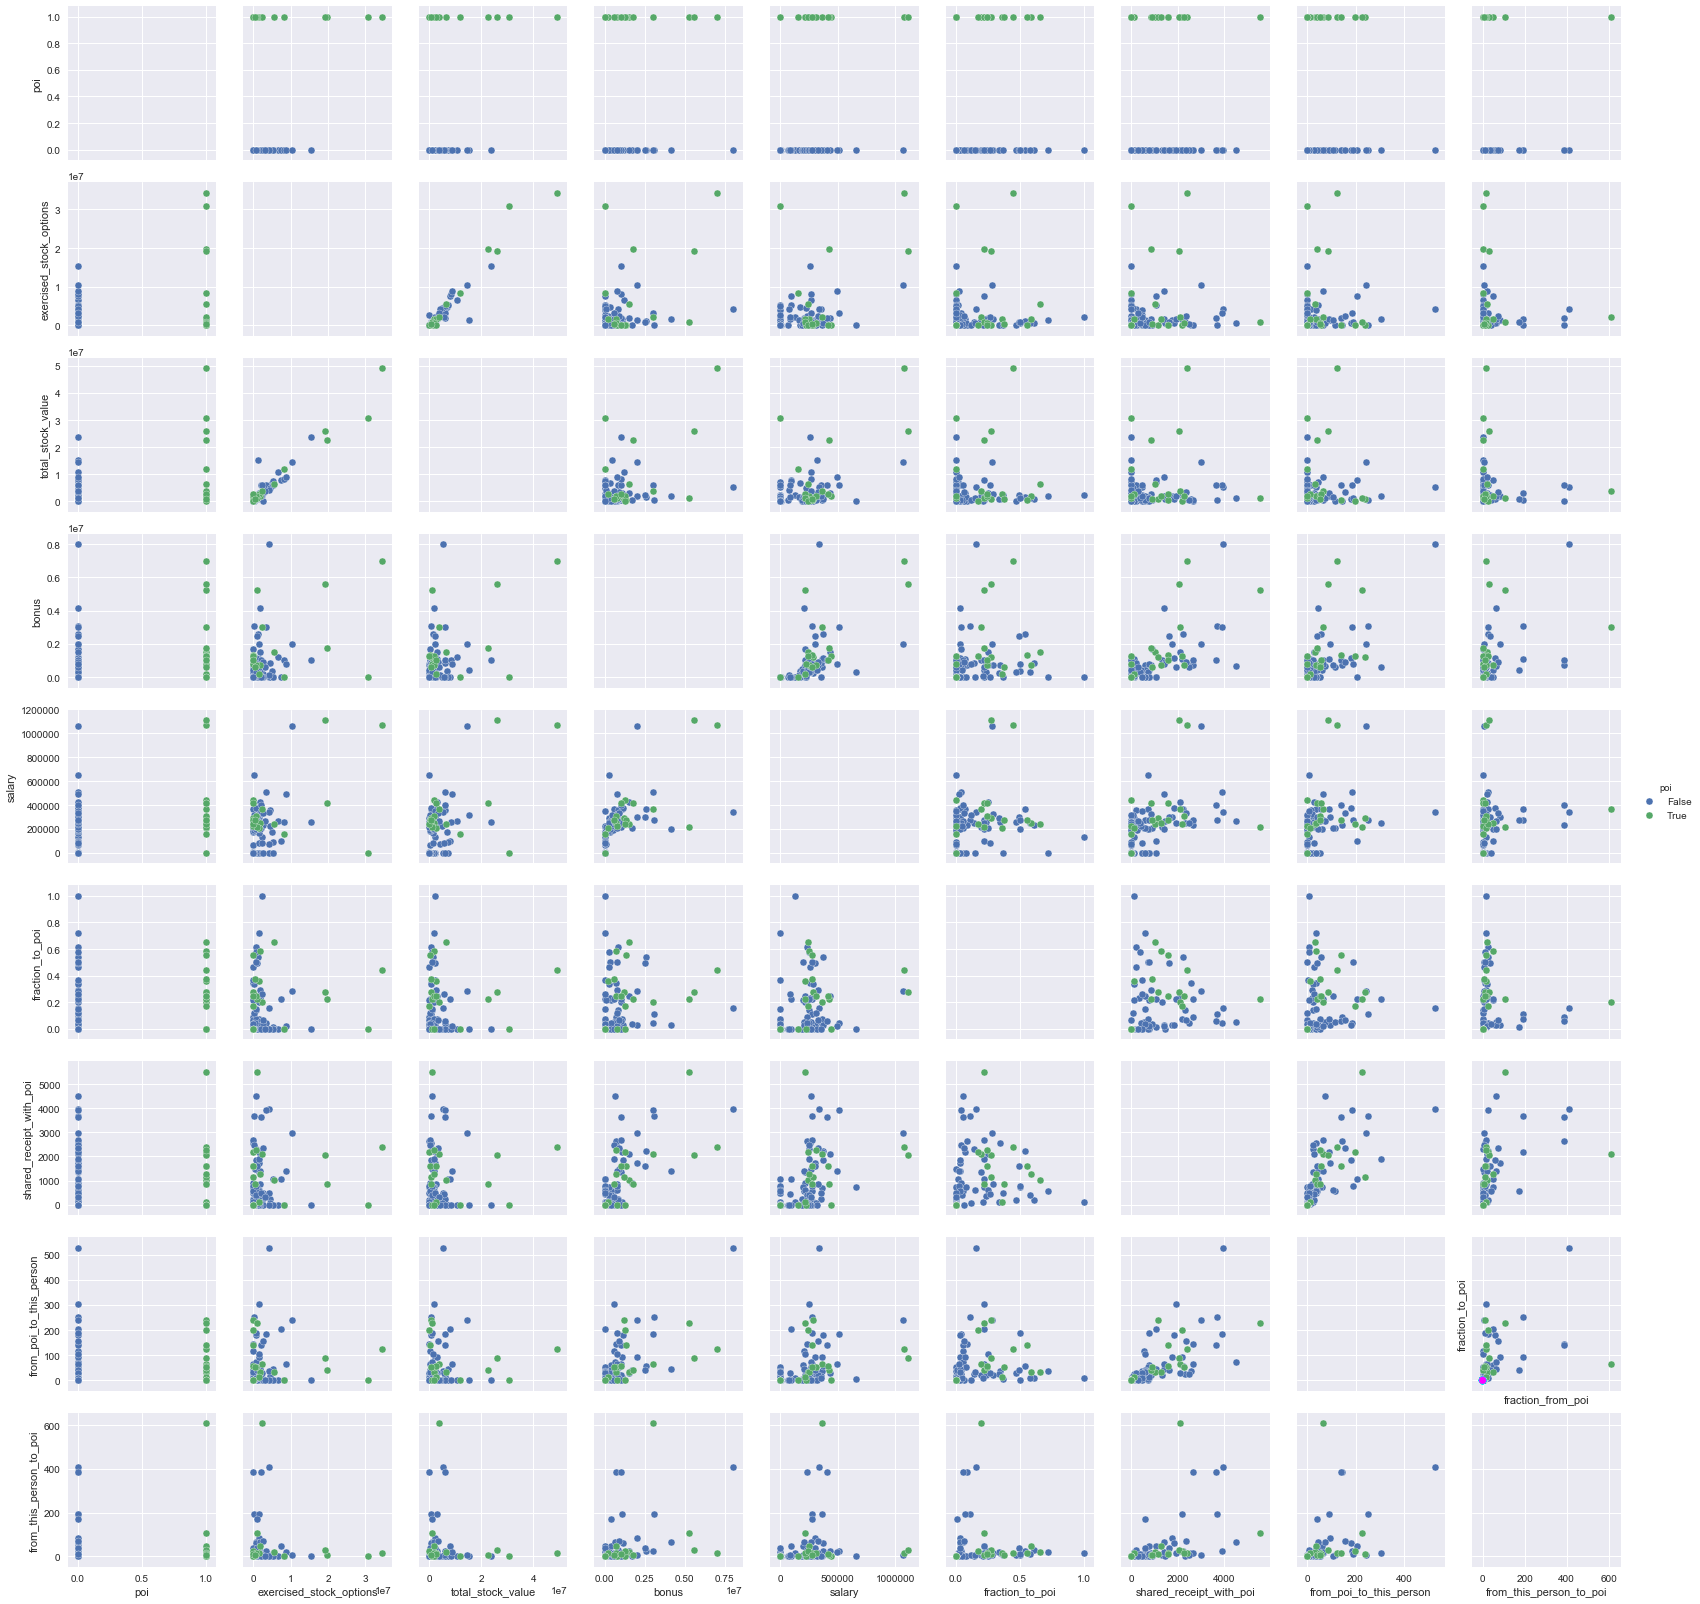

In [26]:
# Visualize new features
x = df['fraction_from_poi'].values
y = df['fraction_to_poi'].values
c = df['poi'].values
plt.scatter(x,y,c=c,cmap='cool')
plt.xlabel("fraction_from_poi")
plt.ylabel("fraction_to_poi")
plt.show()

In the next cell, i am going to extract the features i defined in my list above and select the top 4 features from the financial features and from the email features to help aid my classifier. 

In [27]:
### Extract features and labels from dataset for local testing

# extract the 4 strongest features from the financial data with SelectKBest
financial_data=featureFormat(my_dataset, financial_features_list, sort_keys=True)
financial_labels, financial_features = targetFeatureSplit(financial_data)

# select best features using SelectKBest
test1=SelectKBest(k='all')
fit1=test1.fit(financial_features,financial_labels)

#numpy.set_printoptions(precision=10)
print "printing financial_features k scores: \n", (fit1.scores_)

feature=fit1.transform(financial_features)
# summarize selected features
#print(feature)

#print features
#print labels
#print financial_features[3]

#extract the 4 strongest features from email data with SelectKBest
email_data=featureFormat(my_dataset, email_feature_list, sort_keys = True)
email_labels, email_features=targetFeatureSplit(email_data)

test2=SelectKBest(k='all')
fit2=test2.fit(email_features,email_labels)

print "printing email_features k scores: \n", (fit2.scores_)

printing financial_features k scores: 
[ 18.28968404  20.79225205   0.22461127  11.45847658   2.1263278
  24.81507973   6.09417331   7.18405566   9.92218601   9.21281062
   0.06549965   8.77277773  24.18289868]
printing email_features k scores: 
[  0.29296869   2.43137891   0.46640016   1.0853069    4.61945732
   0.9257389   10.97513201]


After running SelectKBest seperately on the Finanical Data and Email Data. The following features were identified as the top 4 from each group:
* Financial Data:
    - 'exercised_stock_options'	24.81507973
    - 'total_stock_value'	24.18289868
    - 'bonus'	20.79225205
    - 'salary'	18.28968404



* Email Data:
    - 'fraction_to_poi' 10.97513201
    - 'shared_receipt_with_poi'	4.61945732
    - 'from_poi_to_this_person'	2.43137891
    - 'from_this_person_to_poi'	1.0853069




Now i am going to combine these feature to extract the top overal features from this set

In [30]:
financial_email_features=['poi','exercised_stock_options','total_stock_value','bonus','salary','shared_receipt_with_poi',\
                          'from_poi_to_this_person','fraction_to_poi','from_this_person_to_poi']

financial_email_data=featureFormat(my_dataset, financial_email_features, sort_keys = True)
labels, financial_email_features=targetFeatureSplit(financial_email_data)

# select 4 best features using SelectKBest
test3=SelectKBest(k='all')
fit3=test3.fit(financial_email_features,labels)

#numpy.set_printoptions(precision=10)
print "printing financial_email_features k scores: \n", (fit3.scores_)


printing financial_email_features k scores: 
[ 21.71552656  21.05899501  17.8573624   15.14904119   6.8822438
   4.1460684   13.8704061    1.90840396]


After running SelectKBest on the top 4 features from each group combined, I observed the following K scores:

Feature 	               Score
- 'exercised_stock_options'	21.71552656
- 'total_stock_value'	21.05899501
- 'bonus'	17.8573624
- 'salary'	15.14904119
- 'fraction_to_poi' 13.8704061
- 'shared_receipt_with_poi'	6.8822438
- 'from_poi_to_this_person'	4.1460684
- 'from_this_person_to_poi'	1.90840396



 Features from the financial data seem to be the best features to use to input them into our classifier. I'm going to compare this when I run SelectKBest on all features and also to SelectPercentile

In [31]:
''' 
Create new df to produce scatterplot matrix and explore relationships between these 8 features. This will help aid in 
feature selection
'''
new_df = df[['poi','exercised_stock_options','total_stock_value','bonus','salary','fraction_to_poi','shared_receipt_with_poi','from_poi_to_this_person','from_this_person_to_poi']]
# Replace NaN with 0 
new_df=new_df.apply(pandas.to_numeric, errors='coerce').fillna(0)
new_df.head()

,poi,exercised_stock_options,total_stock_value,bonus,salary,fraction_to_poi,shared_receipt_with_poi,from_poi_to_this_person,from_this_person_to_poi
METTS MARK,False,0.0,585062.0,600000.0,365788.0,0.034483,702.0,38.0,1.0
BAXTER JOHN C,False,6680544.0,10623258.0,1200000.0,267102.0,0.000000,0.0,0.0,0.0
ELLIOTT STEVEN,False,4890344.0,6678735.0,350000.0,170941.0,0.000000,0.0,0.0,0.0
CORDES WILLIAM R,False,651850.0,1038185.0,0.0,0.0,0.000000,58.0,10.0,0.0
HANNON KEVIN P,True,5538001.0,6391065.0,1500000.0,243293.0,0.656250,1035.0,32.0,21.0


In [32]:
plt=sns.pairplot(new_df, hue='poi',diag_kind="reg")
plt.savefig("output.png")
#plt.show()

In [33]:
# Explore Feature Scores from entire feature list
full_feature_list=['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees','to_messages','from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi','fraction_from_poi','fraction_to_poi']
full_data=featureFormat(my_dataset, full_feature_list, sort_keys = True)
labels, full_features=targetFeatureSplit(full_data)

# select best features using SelectKBest
test4=SelectKBest(k='all')
fit4=test4.fit(full_features,labels)

#numpy.set_printoptions(precision=10)
print "printing full_features k scores: \n", (fit4.scores_)

feature=fit4.transform(full_features)

#print full_features

printing full_features k scores: 
[ 18.28968404   0.22461127   8.77277773   7.18405566  20.79225205
   0.06549965  11.45847658  24.18289868   6.09417331  24.81507973
   4.18747751   9.92218601   9.21281062   2.1263278    1.64634113
   5.24344971   0.16970095   2.38261211   8.58942073   3.12809175
  16.40971255]


After running SelectKBest on the entire feature list, excluding email address, I observed the following K scores:

Feature 	Score
- 'exercised_stock_options'	24.81507973
- 'total_stock_value'	24.18289868
- 'bonus'	20.79225205
- 'salary'	18.28968404
- 'fraction_to_poi'	16.40971255
- 'deferred_income'	11.45847658
- 'long_term_incentive'	9.92218601
- 'restricted_stock'	9.21281062
- 'total_payments'	8.77277773
- 'shared_receipt_with_poi'	8.58942073
- 'loan_advances'	7.18405566
- 'expenses'	6.09417331
- 'from_poi_to_this_person'	5.24344971
- 'other'	4.18747751
- 'fraction_from_poi'	3.12809175
- 'from_this_person_to_poi'	2.38261211
- 'director_fees'	2.1263278
- 'to_messages'	1.64634113
- 'deferral_payments'	0.22461127
- 'from_messages'	0.16970095
- 'restricted_stock_deferred'	0.06549965


As seen, the top 4 features from this list is the same when I picked out the top 4 features from each group and ran SelectKBest on the combined list. Lets see if this is the same when using Selectpercentile


In [34]:
from sklearn.feature_selection import SelectPercentile, f_classif
test5=SelectPercentile(f_classif, percentile=10)
fit5=test5.fit(full_features,labels)

#numpy.set_printoptions(precision=10)
print "printing full_features k scores: \n", (fit5.scores_)


printing full_features k scores: 
[ 18.28968404   0.22461127   8.77277773   7.18405566  20.79225205
   0.06549965  11.45847658  24.18289868   6.09417331  24.81507973
   4.18747751   9.92218601   9.21281062   2.1263278    1.64634113
   5.24344971   0.16970095   2.38261211   8.58942073   3.12809175
  16.40971255]


After running SelectPercentile, I get the same scores as I did with SelectKBest. After reviewing a scatter plot matrix of the top features from the email and financial features, i am going to try a variety of combinations to see what produces the best out comes. I am going to try a variety of classifiers without any parameter tunes to explore accuracy, recall, precision, and F1 metrics to help me identify which classifiers I should focus on when I go to tune them. 

Since the classifiers I am going to try are not affected by feature scaling, I will not peform any feature scaling.


In [35]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html


# use and extract features identified in previous cell for classifers. 
features_list=['poi','salary',  'bonus', 'total_stock_value', 'exercised_stock_options']
#features_list=['poi','fraction_to_poi',  'shared_receipt_with_poi', 'salary', 'from_poi_to_this_person']
#features_list=['poi','fraction_to_poi',  'shared_receipt_with_poi', 'salary']
#features_list=['poi','fraction_to_poi',   'salary', 'from_poi_to_this_person']
#features_list=['poi','shared_receipt_with_poi', 'salary', 'from_poi_to_this_person']
#features_list=['poi','fraction_to_poi',  'bonus', 'total_stock_value', 'exercised_stock_options']


data=featureFormat(my_dataset, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

# split data into training/testing data useing cross validation
features_train, features_test, labels_train, labels_test=\
    train_test_split(features, labels, test_size=0.3, random_state=42)
# list of classifiers and lists to track metric scores
clf_list=[GaussianNB(),tree.DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier()]
recall_list=[]
mean_recall_list=[]

# Using Stratisfied ShuffleSplit since there is an imbalance of POIs and non P
cv = StratifiedShuffleSplit(random_state=42)
# loop through each classifier and capture evaluation metrics
for c in clf_list:
    clf = c
    clf.fit(features_train,labels_train)
    pred=clf.predict(features_test)
    #print pred
    print "Accuracy is ",clf.score(features_test, labels_test)
    print "precision = ", precision_score(labels_test,pred)
    print "recall = ", recall_score(labels_test,pred)
    recall_list.append(recall_score(labels_test,pred))
    print "\nRunning Stratisfied Shuffle Split cross validation to compare recall\n"
    print "printing mean of Stratisfied Shuffle Split"
    print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
    mean_recall_list.append(cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean())
    print "\n"
    dump_classifier_and_data(clf, my_dataset, features_list)
    main()
print "printing summary of recall score from Classifiers, \n", recall_list
#print "printing summary of accuracy scores from Classifiers, \n", accuracy_list
print "printing summary of mean recall scores from Stratisfied Shuffle Split CV, \n", mean_recall_list

Accuracy is  0.897435897436
precision =  0.0
recall =  0.0

Running Stratisfied Shuffle Split cross validation to compare recall

printing mean of Stratisfied Shuffle Split
mean =  0.25




C:\Users\nmeli\Documents\Udacity\Data Analysis\Anacondas\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GaussianNB(priors=None)
	Accuracy: 0.84677	Precision: 0.50312	Recall: 0.32300	F1: 0.39342	F2: 0.34791
	Total predictions: 13000	True positives:  646	False positives:  638	False negatives: 1354	True negatives: 10362

Accuracy is  0.871794871795
precision =  0.333333333333
recall =  0.25

Running Stratisfied Shuffle Split cross validation to compare recall

printing mean of Stratisfied Shuffle Split
mean =  0.2


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.79008	Precision: 0.32468	Recall: 0.33750	F1: 0.33096	F2: 0.33485
	Total predictions: 13000	True positives:  675	False positives: 1404	False negatives: 1325	True negatives: 9596

Accuracy is  0.923076923077
precision =  1.0

Since I didn’t have a particular algorithm to try in mind, I chose to iterate through several classifiers to evaluate different metrics without making any parameter tunes to get a baseline of how each classifier performs. This will help me choose which classifier to focus tuning parameters on. When iterating, I captured the accuracy of a feature train/test split as well as a mean accuracy when running Stratisfied Shuffle split validation test to compare the two scores. I felt it was necessary to perform Stratisfied Shuffle split cross validation because of the imbalance in POIs and non POIs and to ensure all data is included in a test and a training procedure. Additionally, I dumped out the classifier, dataset, and feature list in each iteration so I can call tester.py. I recorded all the scores the tester file provides scores of each classifier. After iterating through each classier, I observed the following metrics:


|Classifier|Accuracy|Precision|Recall|Mean SSS CV Recall|F1 Score|
|-------|------|------|-------|------|------|
|Naive Bayes |.864|.647|.323|.25|.393|
|Decision Tree|.789|.321|.334|.2|.327|
|Random Forest|.846|.498|.232|.1|.316|
|K Nearest Neighbor|.866|.66|.267|.3|.382|

Due to the drawbacks accuracy can have when evaluating a classifier, I am choosing to focus on Precision and Recall. The classifiers that have the highest precision are:
- Naive Bayes
- K Nearest Neighbor

The classifiers that have the highest recall are :
- Decision Tree
- Naïve Bayes

Metrics for SVC was not recorded due to errors. I am going to try some feature scaling and parameter tunes to see if that helps the issue now and re-evaluate. 


In [ ]:


features_list=['poi','salary',  'bonus', 'total_stock_value', 'exercised_stock_options']
data=featureFormat(my_dataset, features_list, sort_keys=True)
labels, features=targetFeatureSplit(data)
new_finance_features=numpy.array(features) +0.

scaler = MinMaxScaler()
rescaled_features=scaler.fit_transform(new_finance_features)

#print "printing rescaled_features \n", rescaled_features

param_grid1={'C': [1, 10, 100, 1000],},
param_grid2={'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
param_grid3={'C': [1, 10, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

features_train1, features_test1, labels_train1, labels_test1=\
    train_test_split(rescaled_features, labels, test_size=0.3, random_state=42)


clf = GridSearchCV(SVC(kernel='rbf'), param_grid1,scoring='recall')
clf.fit(features_train1, labels_train1)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)    
    
    

In [ ]:
clf=SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf.fit(features_train1,labels_train1)
pred=clf.predict(features_test1)
#print pred
print "Accuracy is ",clf.score(features_test1, labels_test1)
print "\nRunning 10 fold cross validation to compare accuracy\n"
print "printing mean of 10 fold CV"
print "mean = ",cross_val_score(clf,rescaled_features,labels,cv=10,scoring='accuracy').mean()
print "\n"
print "precision = ", precision_score(labels_test1,pred)
print "recall = ", recall_score(labels_test1,pred)
dump_classifier_and_data(clf, my_dataset, features_list)
main()

    


It doesnt look like feature scaling or parameter tunes helped much in terms of evaulating Precision and Recall. 

Having good recall means that nearly every time a POI shows up in my test set, I am able to identify him or her. Because of this, I am going to try and tune the classifiers that have the highest baseline of recall to see if I can improve the recall score. I feel this is the important metric to focus on because I want to make sure I dont miss a POI when they show up in the test set. When applying this to the enron case, I feel it is more important to be able to identify POIs even if there are some false positives. False postives can be proven innocent through court trials and rulings made on the individuals. However, if a POI is missed, they could walk free and never be brought to justice. 

Since parameter tuning is not needed on Naive Bayes, I am going to do paramater tuning on the alogrithms I initially tried. 


In [36]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Tuning Decision Tree


param_grid={'criterion':('gini','entropy'),'splitter':('best','random'),'min_samples_split':[2,50,100,1000],
                'max_features':[1,2,3],}
cv = StratifiedShuffleSplit(random_state=42)
clf1=tree.DecisionTreeClassifier()
clf=GridSearchCV(clf1, param_grid,scoring='recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
{'max_features': 3, 'min_samples_split': 2, 'criterion': 'gini', 'splitter': 'random'}
17
0.45


In [37]:
# Tune Decision Tree
clf=tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')

clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

Accuracy is  0.846153846154
precision =  0.333333333333
recall =  0.5

Running Stratisfied Shuffle split to compare accuracy

printing mean of Stratisfied Shuffle Split fold CV
mean =  0.2


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')
	Accuracy: 0.78654	Precision: 0.30673	Recall: 0.30750	F1: 0.30712	F2: 0.30735
	Total predictions: 13000	True positives:  615	False positives: 1390	False negatives: 1385	True negatives: 9610



When doing parameter tuning on Decision Tree using GridsearchCV, i had to set the scorer to recall in order to get the parameters that produced the highest recall. This seemed to help as I now get a recall score of .33. Let see how the other algorithms do. 

In [38]:
# Tune Random Forest
param_grid={'min_samples_split':[2,50,100],
                'n_estimators':[5,10,50,100],}

clf1=RandomForestClassifier()
clf=GridSearchCV(clf1, param_grid,scoring='recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)
#print(clf.feature_importances_)

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'min_samples_split': 2, 'n_estimators': 5}
0
0.35


In [39]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

Accuracy is  0.923076923077
precision =  1.0
recall =  0.25

Running Stratisfied Shuffle split to compare accuracy

printing mean of Stratisfied Shuffle Split fold CV
mean =  0.3


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
	Accuracy: 0.82269	Precision: 0.38860	Recall: 0.26600	F1: 0.31582	F2: 0.28392
	Total predictions: 13000	True positives:  532	False positives:  837	False negatives: 1468	True negatives: 10163



When doing some parameter tuning on RandomForest, my recall improves a little bit but not enough as it is still below .3. I will try parameter tuning on some other algorithms and see if I can get the recall score above .3

In [40]:
# Tune K Nearest Neighbors
k=numpy.arange(10)+1
param_grid={'n_neighbors':k}

clf1=KNeighborsClassifier()
clf=GridSearchCV(clf1, param_grid,scoring = 'recall',cv=cv)
clf.fit(features_train, labels_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_index_)
print(clf.best_score_)



Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
{'n_neighbors': 1}
0
0.35


In [41]:
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare accuracy\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean = ",cross_val_score(clf,features,labels,cv=cv.split(features,labels),scoring='recall').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()

Accuracy is  0.846153846154
precision =  0.333333333333
recall =  0.5

Running Stratisfied Shuffle split to compare accuracy

printing mean of Stratisfied Shuffle Split fold CV
mean =  0.3


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.84369	Precision: 0.48973	Recall: 0.38150	F1: 0.42889	F2: 0.39914
	Total predictions: 13000	True positives:  763	False positives:  795	False negatives: 1237	True negatives: 10205



After doing some parameter tunes on my classifier algorithms, I observed the following results:

|Classifier|Accuracy|Precision|Recall|Mean SSS Fold CV Recall|F1 Score|True positives|False positives|False negatives|True negatives|
|-------|------|------|-------|------|------|-------|------|------|-----|
|Decision Tree|.797|.342|.348|.3|.345|695|1336|1305|9664|
|Random Forest|.829|.418|.279|.25|.334|557|744|1433|10226|
|K Nearest Neighbor|.844|.49|.382|.3|.429|763|795|1237|10205|


Cleary, the algorithm the benefited the most from parameter tuning was K Nearest Neighbor. It achieved the highest recall from all the classifiers I explored with and without parameter tunes. Now I am going to use K Nearest Neighbor with the optimal value for K and evaluate the precision and recall i get when testing the classifier. 

In [44]:
# Run K Nearest Neighbor with optimal K Value and dump out performance metrics. This is my final choice for my classifier.
# I am also going to explore feature scaling on KNN to compare the evaluation metrics


features_list=['poi','salary',  'bonus', 'total_stock_value', 'exercised_stock_options']
data=featureFormat(my_dataset, features_list, sort_keys=True)
labels, features=targetFeatureSplit(data)
new_features=numpy.array(features) +0.

scaler = MinMaxScaler()
rescaled_features=scaler.fit_transform(new_features)

features_train, features_test, labels_train, labels_test=\
    train_test_split(rescaled_features, labels, test_size=0.3, random_state=42)

clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


clf.fit(features_train,labels_train)

pred=clf.predict(features_test)
    #print pred
print "Accuracy is ",clf.score(features_test, labels_test)
print "precision = ", precision_score(labels_test,pred)
print "recall = ", recall_score(labels_test,pred)
print "\nRunning Stratisfied Shuffle split to compare recall\n"
print "printing mean of Stratisfied Shuffle Split fold CV"
print "mean recall = ",cross_val_score(clf,features,labels,cv=cv.split(rescaled_features,labels),scoring='recall').mean()
print "mean precision = ",cross_val_score(clf,features,labels,cv=cv.split(rescaled_features,labels),scoring='precision').mean()
print "\n"
dump_classifier_and_data(clf, my_dataset, features_list)
main()


Accuracy is  0.846153846154
precision =  0.333333333333
recall =  0.5

Running Stratisfied Shuffle split to compare recall

printing mean of Stratisfied Shuffle Split fold CV
mean recall =  0.3
mean precision =  0.35


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
	Accuracy: 0.84369	Precision: 0.48973	Recall: 0.38150	F1: 0.42889	F2: 0.39914
	Total predictions: 13000	True positives:  763	False positives:  795	False negatives: 1237	True negatives: 10205



As seen from above, when running Stratisfied Shuffle Split on re-scaled features, I achieve a mean recall of .3 and a mean precision of .35. When the tester.py file is called, I achieve a recall of .382 and a precision of .49. It seems like feature scaling didnt have much effect. 

In [45]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)